In [1]:
%matplotlib notebook
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import glob

sys.path.append("../../../libs/")
import HEq
import MosaicFitsReader as mfr

In [73]:
 def centroid(arr):
    """
    One step 1D centroiding algo.
    Returns centroid position and standard deviation
    """
    l = arr.shape[0]
    ixs = np.arange(l)
    arr = arr - np.median(arr)
    arr = np.where(arr < 0, 0, arr)    
    ixs2 = ixs * ixs
    sumarr = arr.sum()
    cen = np.dot(arr, ixs)/sumarr
    return cen, math.sqrt(np.dot(arr, ixs2)/sumarr - cen * cen)

def centroidLoop(arr, fromIdx, toIdx, nLoops=10, epsilon=1E-1):
    def limit(x):
        if x < 0: return 0
        if x >= length: return length
        return x
    
    length = len(arr)
    radius = (toIdx - fromIdx)/2
    lastCenPos = -9999
    for i in range(nLoops):
        fromIdx = int(limit(fromIdx))
        toIdx = int(limit(fromIdx + radius + radius + 0.5))
        pos, cenStd = centroid(arr[fromIdx:toIdx])
        cenPos = pos + fromIdx
        #print (i, fromIdx, toIdx, cenPos, cenStd, lastCenPos)
        
        if cenPos < fromIdx or toIdx < cenPos:
            return -1, 0, 0, i
        
        if abs(lastCenPos - cenPos) < epsilon:
            return 0, cenPos, cenStd, i
        if cenStd > radius/3:
            return -1, cenPos, cenStd, i
        fromIdx = cenPos - radius
        lastCenPos = cenPos
        
    return -1, cenPos, cenStd, i  

In [74]:
def findWidth (cut1d):
    out = []
    for x in range(0, len(cut1d)-60, 60):
        ok, cen, std, idx = centroidLoop(cut1d, x, x+60)     
        #print (res)
        if ok == 0:
            out.append((std, cen))
    #print (out)
    if len(out) <= 0:
        return []
    out = sorted(out)
    return [s for s, x in out[:len(out)//2]]

In [75]:
out = []
for f in range(8, 15):
    fname = "bfoc%04d.fits" % f
    ffile = mfr.MosaicFitsReader(fname)
    img = ffile.data
    blueFocus = ffile.getKeyword('BLUFOCUS')
    if blueFocus == None:
        continue
    cut1d = img[:,1800]
    widths = findWidth(cut1d)
    out.append((blueFocus, widths))

In [76]:
def makePairs(data):
    for a, b in data:
        for c in b:
            yield (a, c)
            
def calcAsymptote(A, B, C):
    h = -B/A/2
    a2 = C - A * h*h
    b2 = a2/A
    m0 = math.sqrt(a2/b2)
    b0 = -m0 * h
    return m0, b0, h

def asympFunc(m, b):
    def f(x):
        return m * x + b
    return f

In [77]:
pairs = np.array(list(makePairs(out))).T

In [79]:
res = np.polyfit(pairs[0], np.multiply(pairs[1], pairs[1]), deg=2)
func = np.poly1d(res)
def func1 (x):
    return math.sqrt(func(x))

funcV = np.vectorize(func1)

In [80]:
A, B, C = res
m0, b0, minX = calcAsymptote(A, B, C)
print ("minX", minX, "Asymp", m0, b0)

minX -3509.03016741 Asymp 0.009697661831131528 34.0293879187


<IPython.core.display.Javascript object>


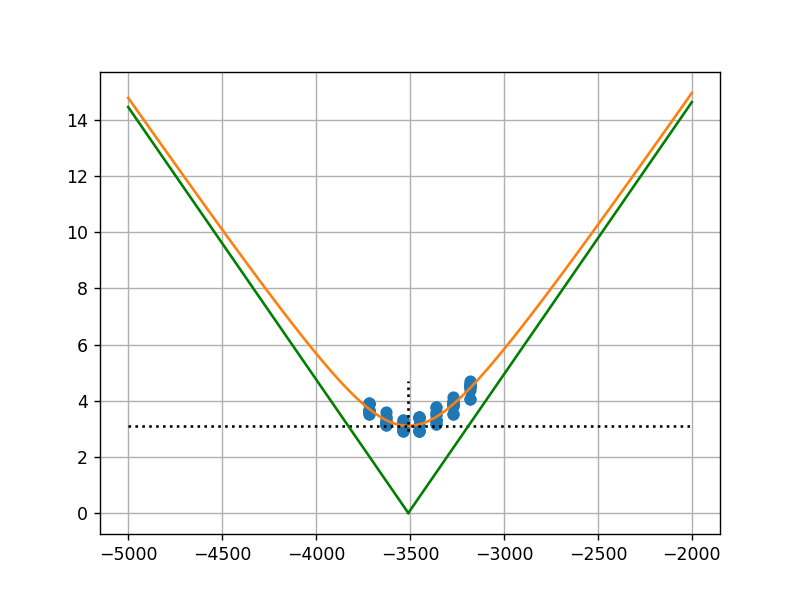

In [81]:
plt.plot(pairs[0], pairs[1], 'o')
x0, x1 = -5000, -2000 # min(pairs[0]), max(pairs[0])
xs = np.linspace(x0, x1, 100)

plt.plot(xs, funcV(xs))

plt.plot((x0, x1), (funcV(minX), funcV(minX)), 'k:')
plt.plot((minX, minX), (min(pairs[1]), max(pairs[1])), 'k:')

posAsymp = asympFunc(m0, b0)
negAsymp = asympFunc(-m0, -b0)

plt.plot((x0, minX), (negAsymp(x0), negAsymp(minX)), 'g-')
plt.plot((minX, x1), (posAsymp(minX), posAsymp(x1)), 'g-')
plt.grid()

In [49]:

negAsymp(-3500)

67.971204327698075

In [54]:
-3500 * (-m0) - b0

-0.087571509777369272